In [1]:
import random
random.seed(2024)

import missingno as msno
import numpy as np
from scipy.stats import shapiro
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from fasteda import fast_eda

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [2]:
# Load the data from `sklearn` as two pandas.DataFrame
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Concatenate the two pandas.DataFrames into one
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the data set from `sklearn` using another method in order to print 
# the data set description of the data
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [3]:
diabetes.isna().max(axis=0).max()

np.False_

In [4]:
# Set the random seed for reproducibility
random.seed(2024)

# Select 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

# Select 10% of the rows at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))

# Set the 3 selected columns to miss
# ing values for the 10% of selected rows
diabetes.iloc[missing_rows, missing_cols] = np.nan

In [5]:
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


In [6]:
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])
diabetes = pd.concat([diabetes, encoded_sex], axis=1)
diabetes[['sex', 'sex1', 'sex2']].sample(10)

sex  sex1  sex2
289  2.0   0.0   1.0
15   2.0   0.0   1.0
371  2.0   0.0   1.0
77   1.0   1.0   0.0
360  1.0   1.0   0.0
251  2.0   0.0   1.0
384  2.0   0.0   1.0
269  1.0   1.0   0.0
248  1.0   1.0   0.0
228  1.0   1.0   0.0

In [7]:
diabetes = diabetes.drop(['sex', 'sex2'], axis=1)
diabetes = diabetes.loc[:, ['age', 'sex1', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]
diabetes.sample(5)

age  sex1   bmi     bp     s1     s2    s3   s4      s5     s6  target
155  41.0   0.0  32.0  109.0  251.0  170.6  49.0  5.0  5.0562  103.0   186.0
365  58.0   1.0  22.8   91.0  196.0  118.8  48.0  4.0  4.9836  115.0   206.0
212  67.0   1.0   NaN  105.0    NaN  135.4  69.0  NaN  4.6347   96.0    73.0
132  53.0   0.0  24.4   92.0  214.0  146.0  50.0  4.0  4.4998   97.0   107.0
154  67.0   0.0  28.3   93.0  204.0  132.2  49.0  4.0  4.7362   92.0   197.0

In [8]:
# Make a train-test split
X_train, X_test, y_train, y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, [-1]], test_size=0.33, random_state=2024)

In [9]:
diabetes.head()


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0   1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0   1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

In [10]:
diabetes.tail()

age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
437  60.0   0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0   0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0   0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0   1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0   1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

In [11]:
diabetes.describe()

age        sex1         bmi          bp          s1          s2  \
count  442.000000  442.000000  398.000000  442.000000  398.000000  442.000000   
mean    48.518100    0.531674   26.425879   94.647014  189.266332  115.439140   
std     13.109028    0.499561    4.445336   13.831283   34.391866   30.413081   
min     19.000000    0.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    0.000000   23.125000   84.000000  165.000000   96.050000   
50%     50.000000    1.000000   25.800000   93.000000  186.000000  113.000000   
75%     59.000000    1.000000   29.500000  105.000000  209.000000  134.500000   
max     79.000000    1.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6      target  
count  442.000000  398.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.075075    4.641411   91.260181  152.133484  
std     12.934202    1.282526    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

In [12]:
diabetes.isna().sum()

age        0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

<Axes: >

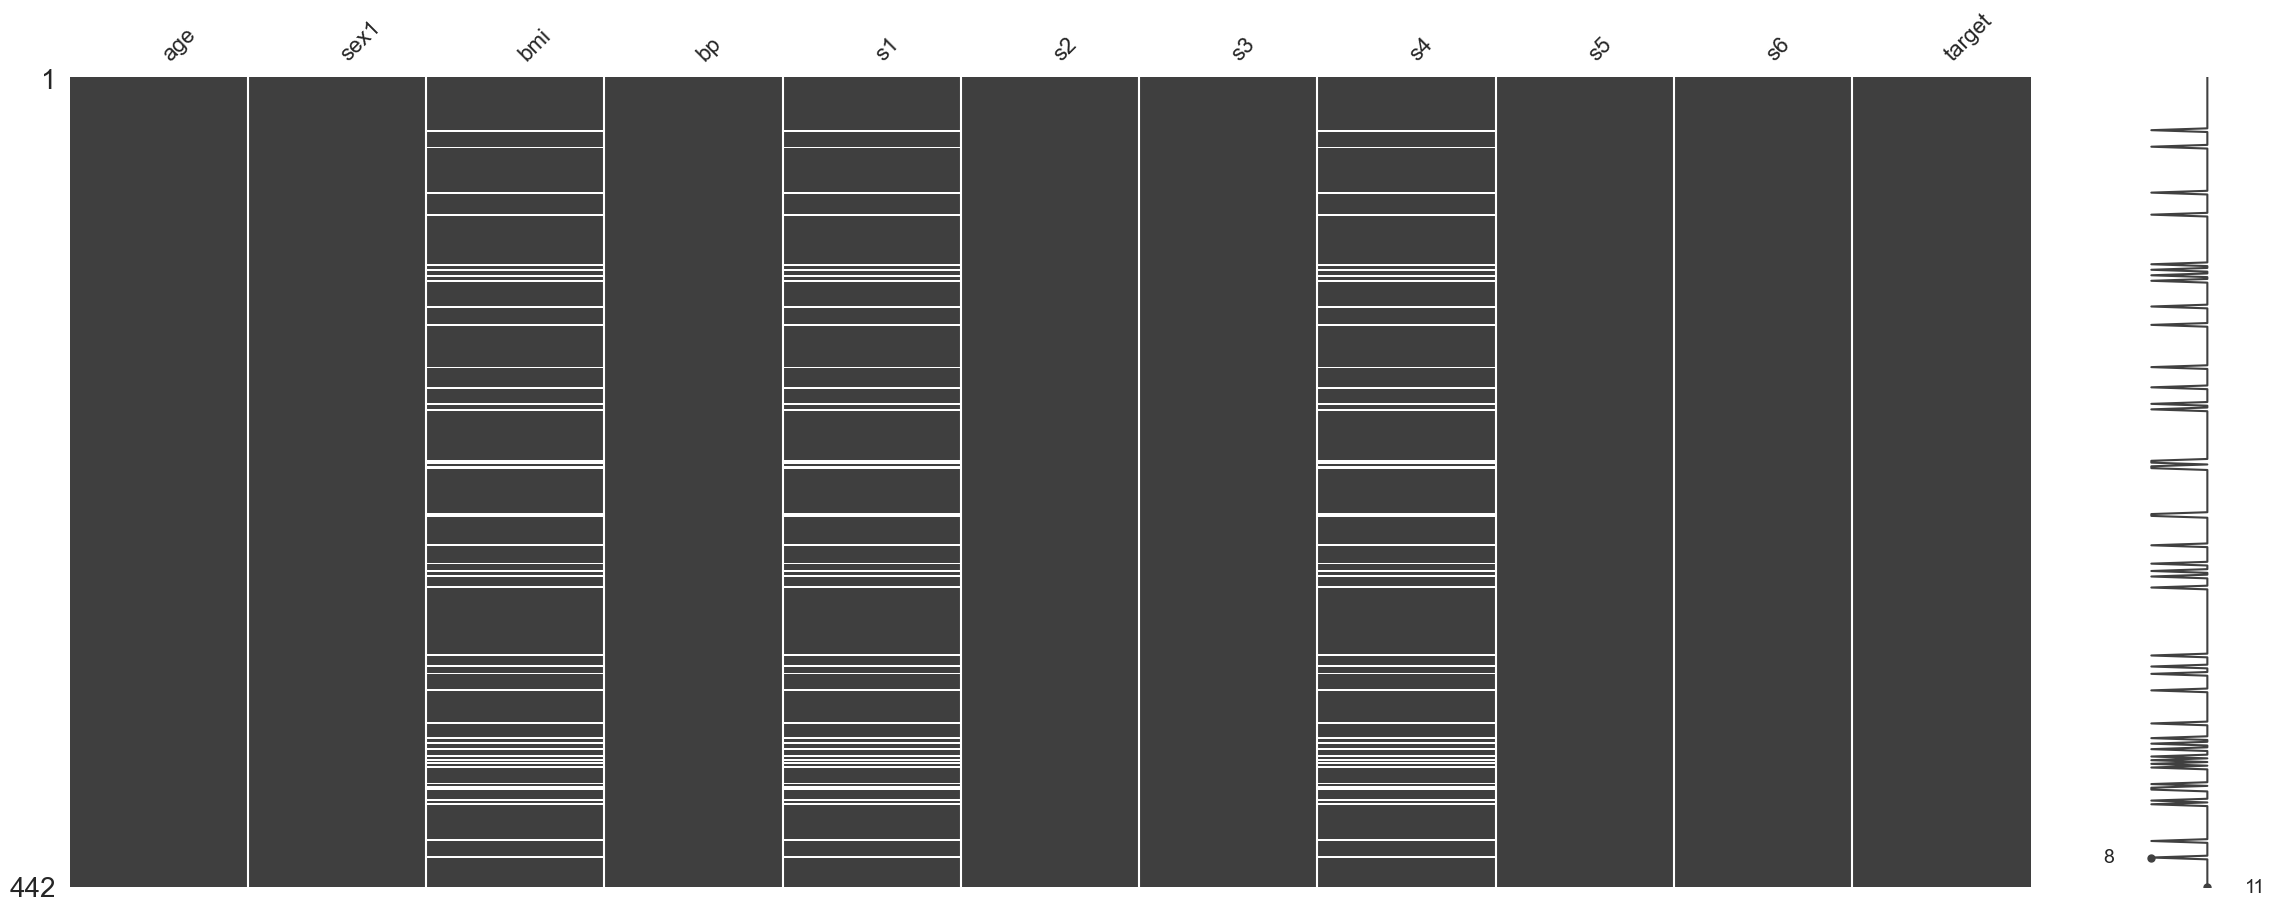

In [13]:
msno.matrix(diabetes)

In [14]:
diabetes.index[diabetes['bmi'].isna()][0]

np.int64(29)

In [15]:
# linear regression dropping NANs

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(56.0267829057821)

In [16]:
# linear regression with mean fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Fit the simple imputer using the training data
imp_mean.fit(X_train)
# Actually mean fill the training data
X_train_mean_filled = imp_mean.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_mean_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(55.731388480882835)

In [17]:
# linear regression with median fill

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median =SimpleImputer(missing_values=np.nan,strategy='mean')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(55.731388480882835)

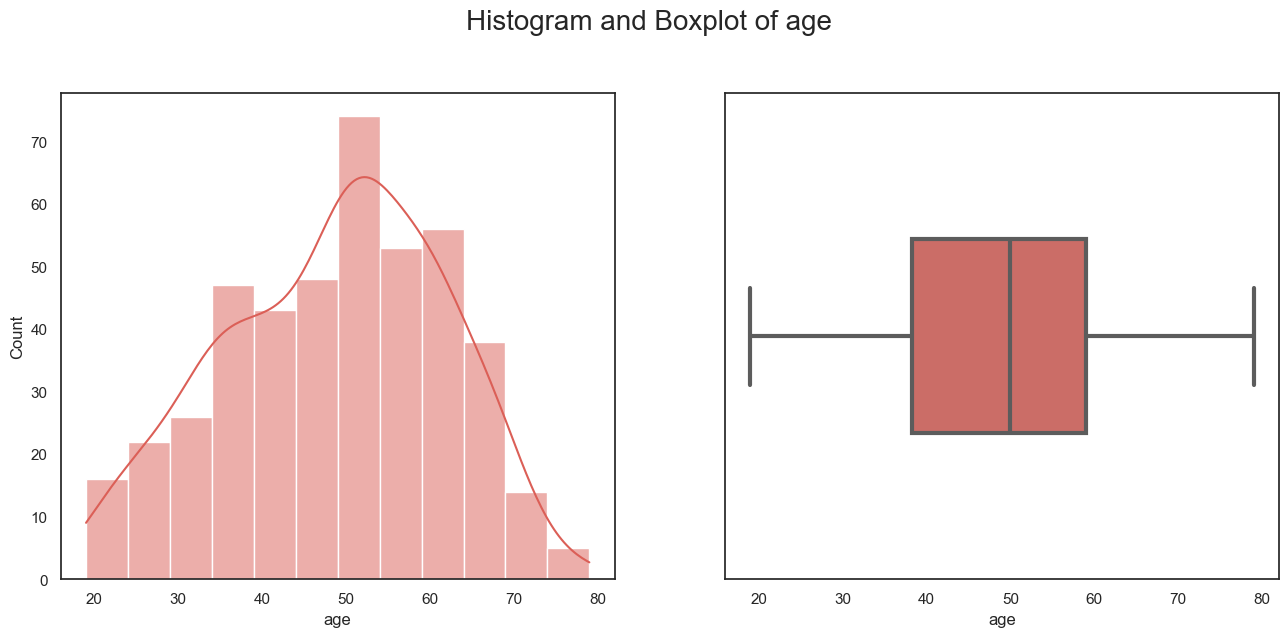

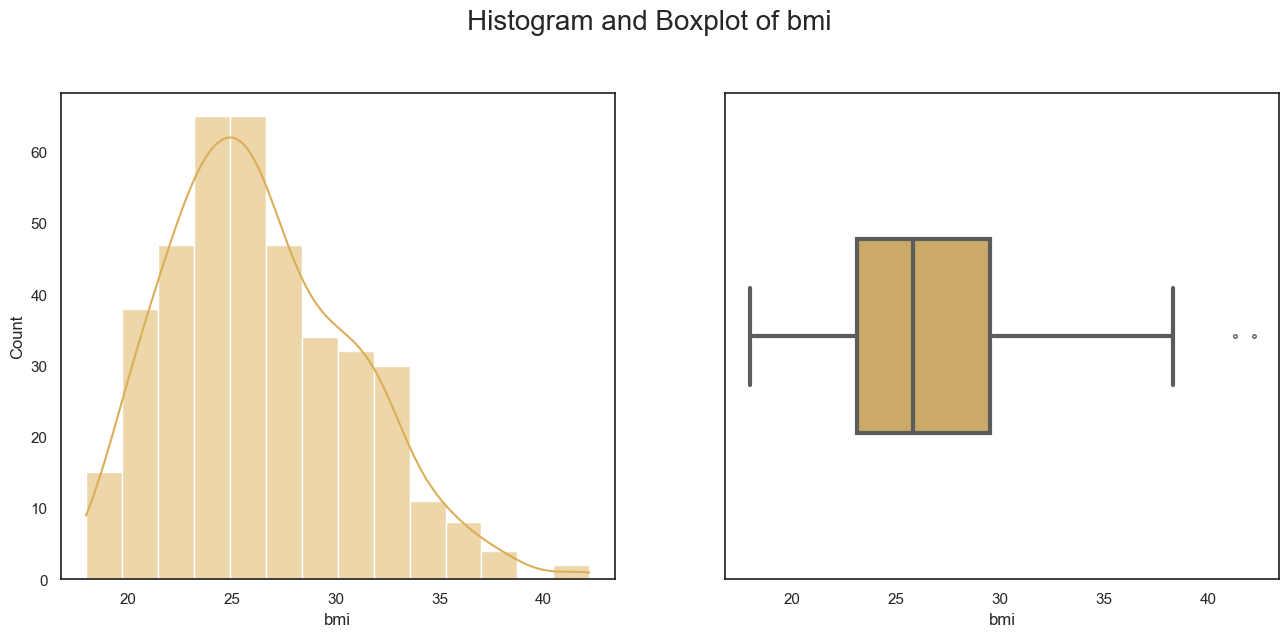

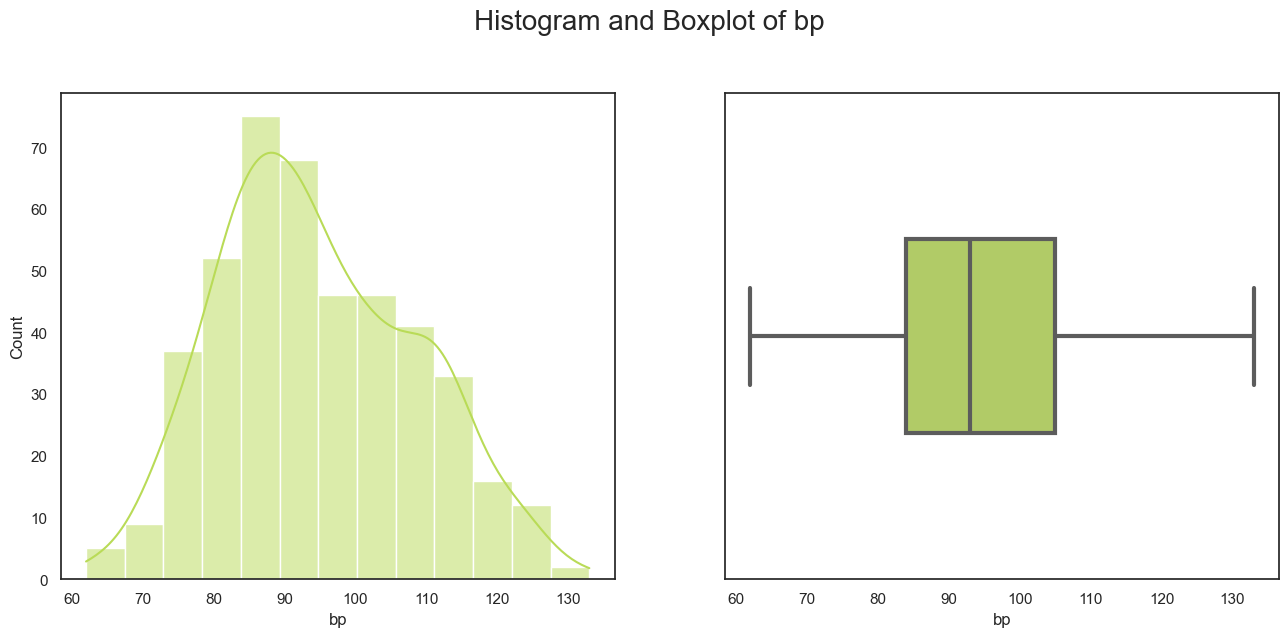

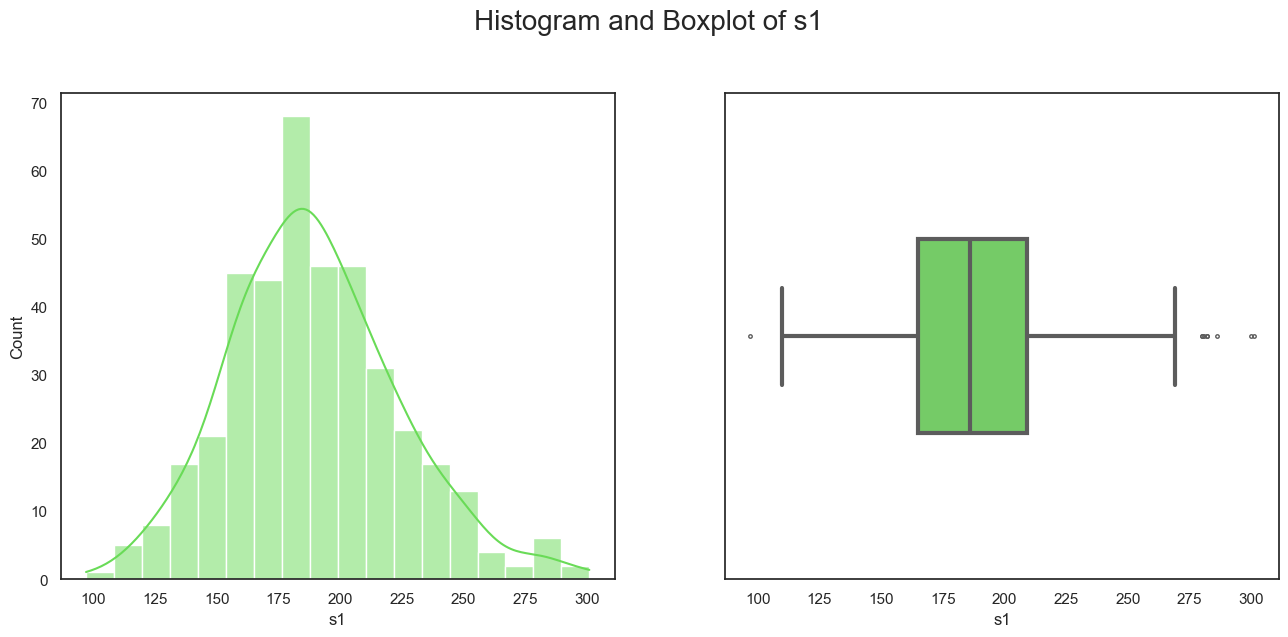

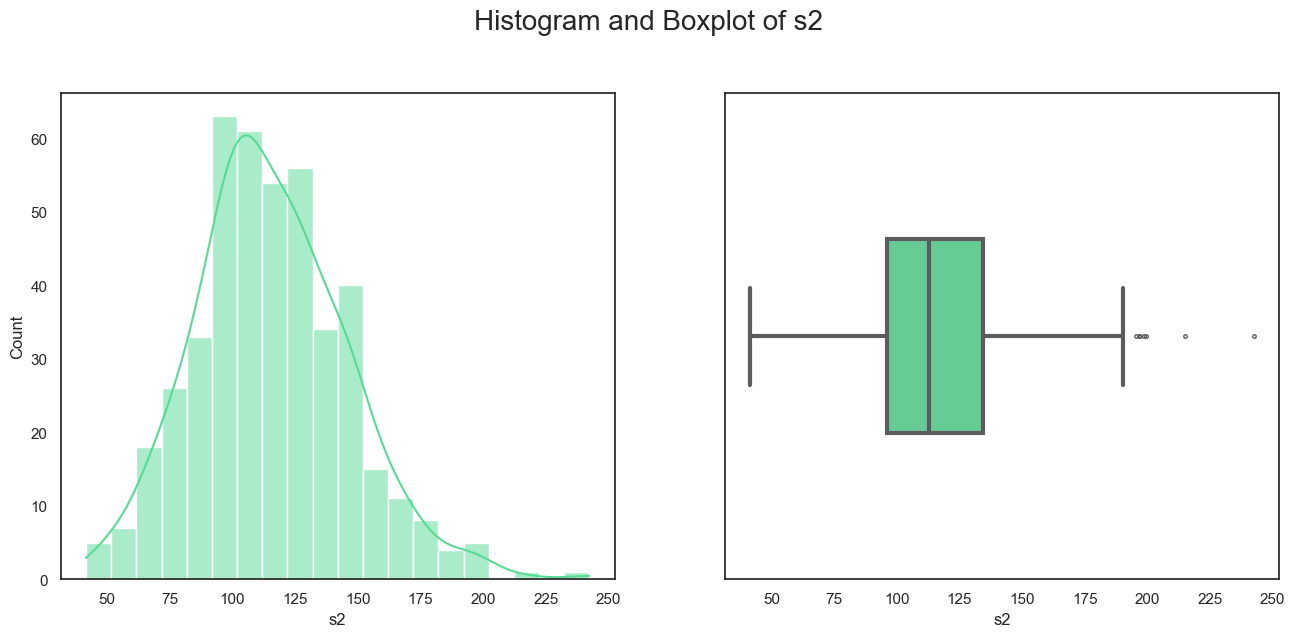

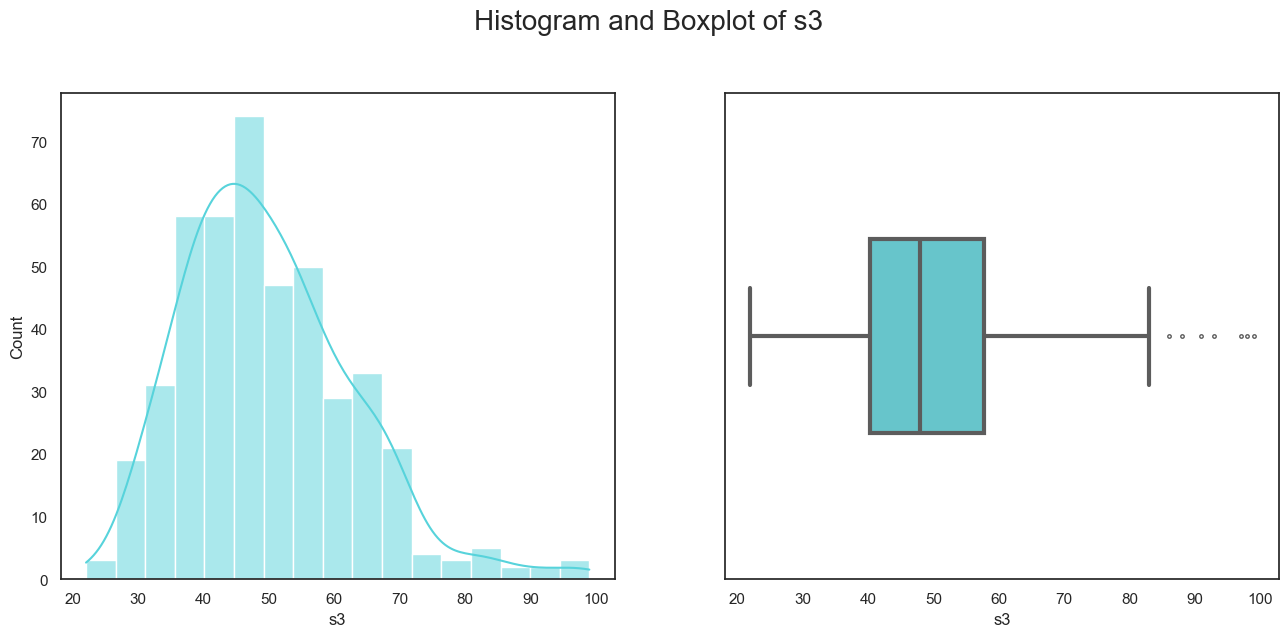

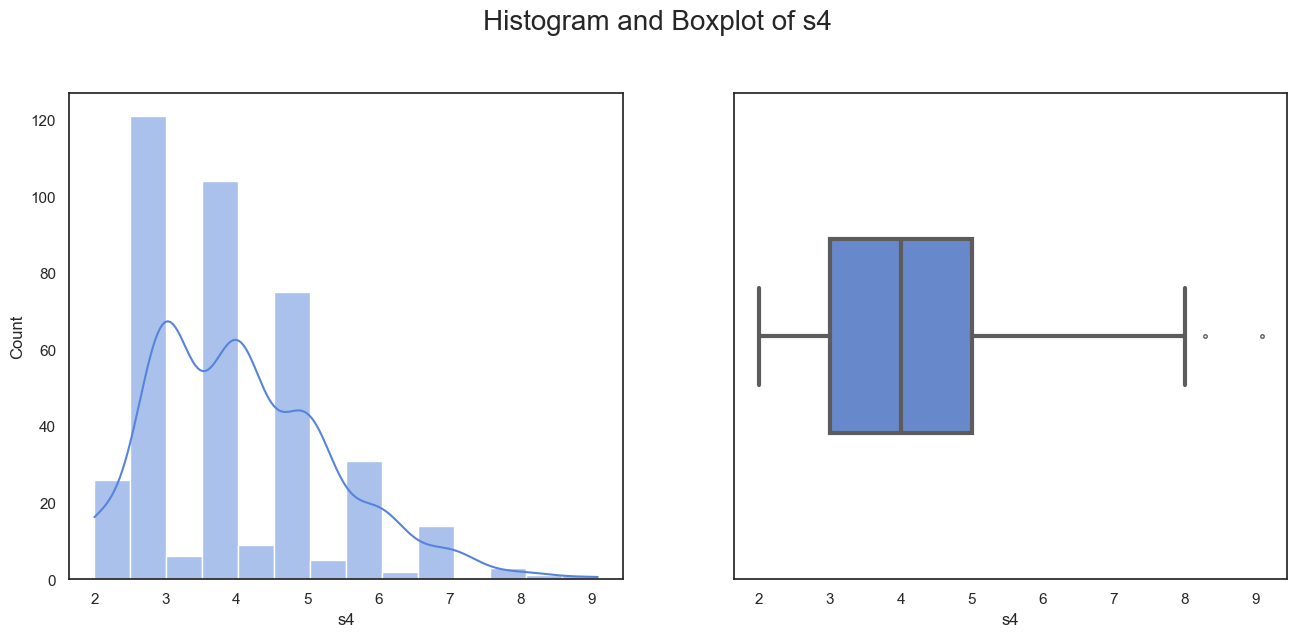

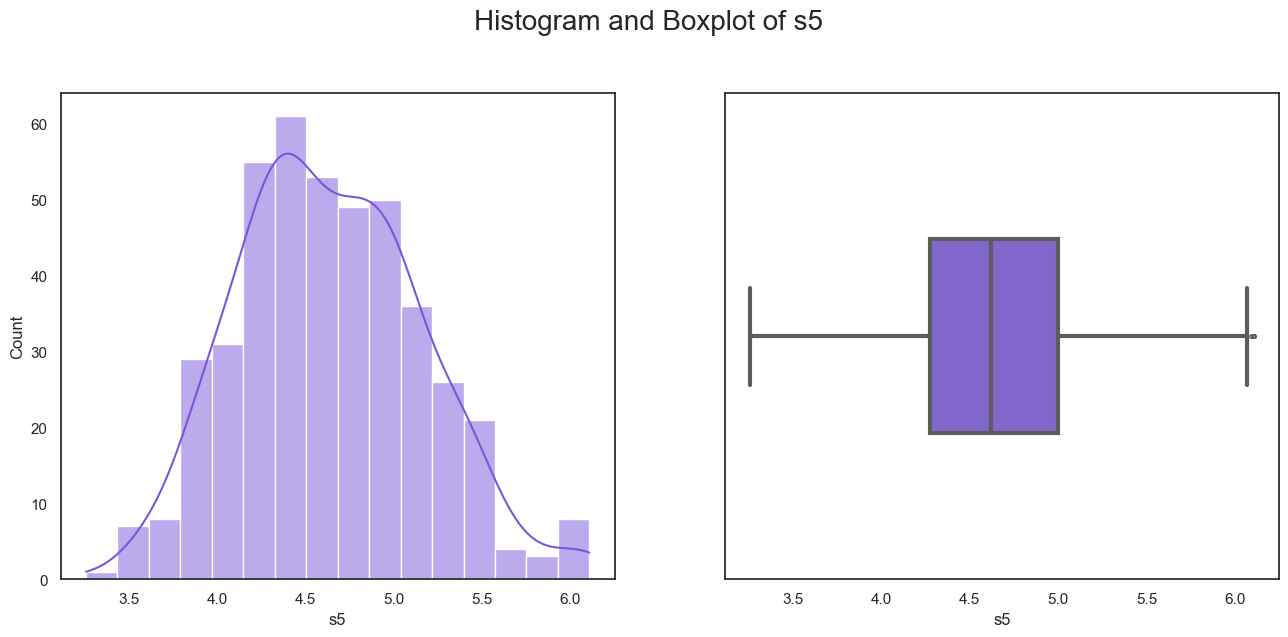

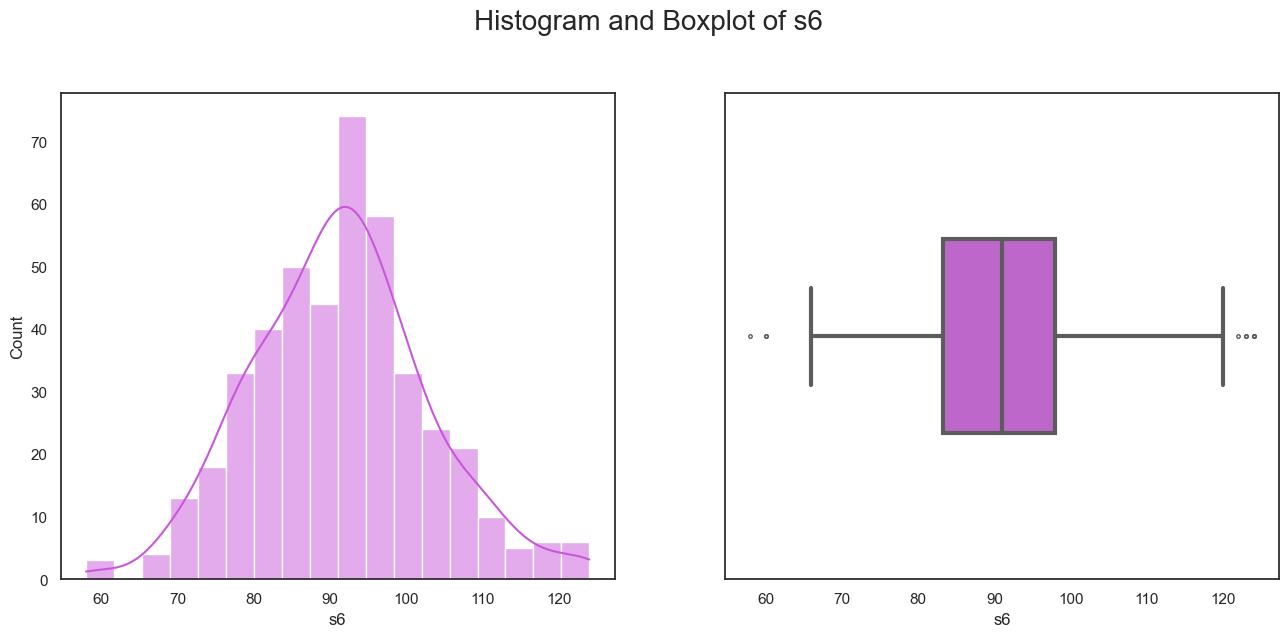

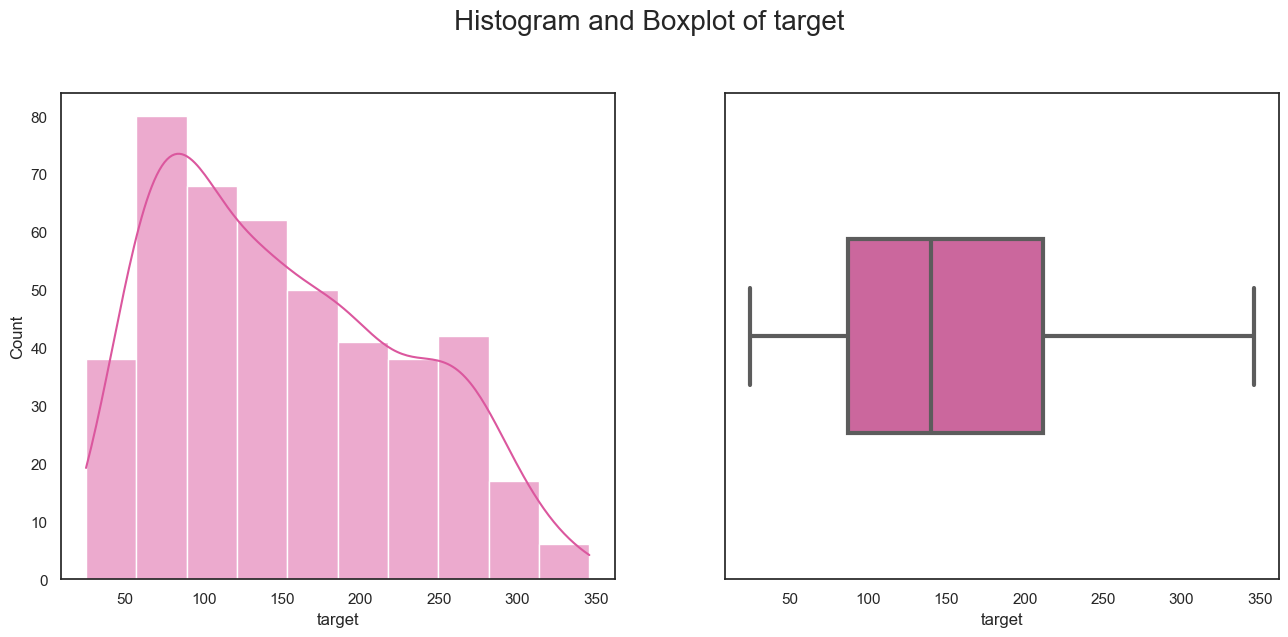

In [18]:
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

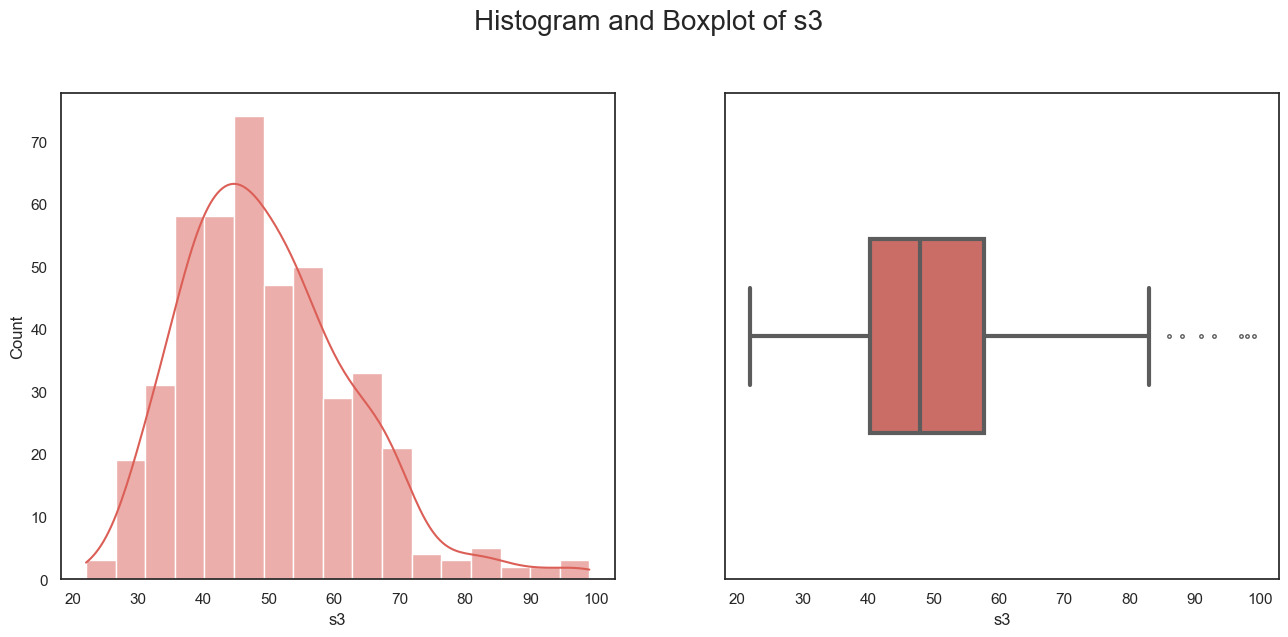

In [19]:
for idx, col in enumerate(['s3']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s3']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s3']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [20]:
# normality test on s3
stat, p = shapiro(X_train['s3'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.962, p=0.000
Sample does not look normally distributed (reject H0)


In [21]:
# normality test on log of s3
stat, p =shapiro(X_train['s3'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks normally distributed (fail to reject H0)')
else:
    print('Sample does not look normally distributed (reject H0)')

Statistics=0.962, p=0.000
Sample does not look normally distributed (reject H0)


In [22]:
# linear regression with median fill, and using the log of 's3'

X_train['s3'] = np.log(X_train['s3'])
X_test['s3'] = np.log(X_test['s3'])

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(55.54182281209479)

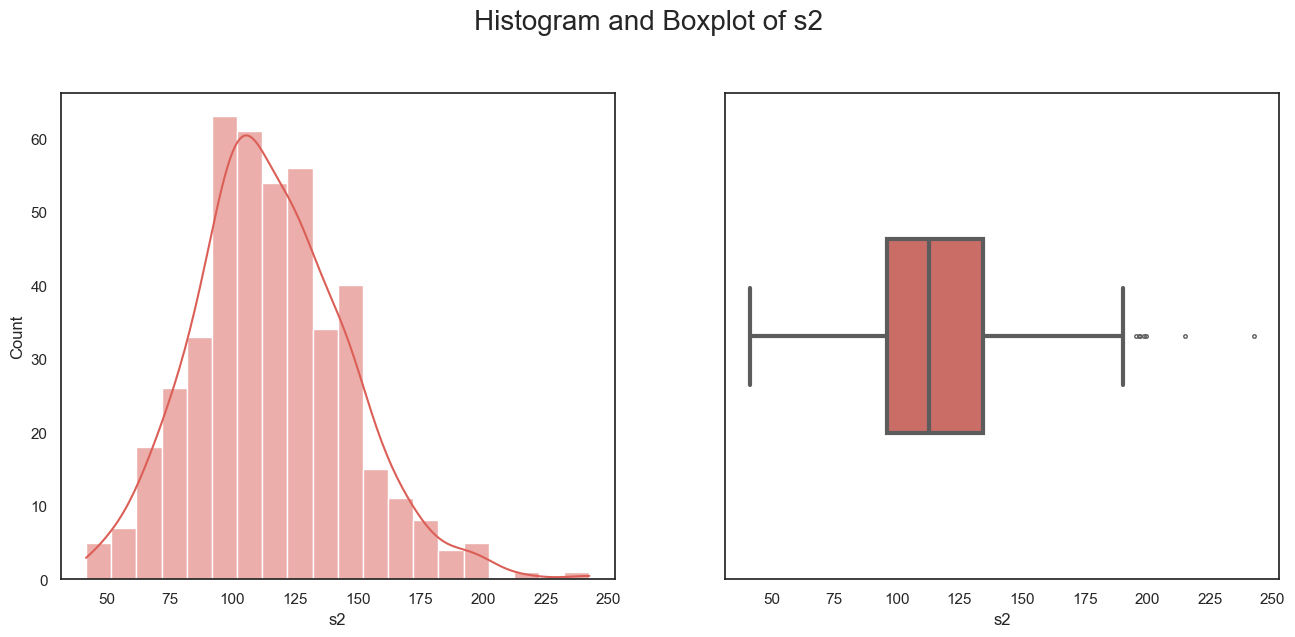

In [23]:
for idx, col in enumerate(['s2']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(diabetes, x = diabetes[col], kde = True,
                 color = sns.color_palette("hls", len(['s2']))[idx], ax = ax1)
    sns.boxplot(x = diabetes[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", len(['s2']))[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

In [24]:
# linear regression with median fill, using the log of 's3', and removal of outlier from 's2':

# Outlier removal
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train)
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train)

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(55.36663047771339)

In [25]:
# linear regression with median fill, using the log of 's3', removal of outlier from 's2', and the dropping of 's1':
"""
# Outlier removal (commented out because `X_train` and `y_train` are already updated)
X_train_nonoutlier_idx = X_train.index[X_train.s2 < X_train.s2.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Get NAN indices (commented out because these indices did not change)
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]
"""
# Get column names that do not include 's1'
cols_no_s1 = [i for i in X_train.columns if i != 's1']

# Initialize the simple imputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# Fit the simple imputer using the training data
imp_median.fit(X_train.loc[:, cols_no_s1])
# Actually median fill the training data
X_train_median_filled = imp_median.transform(X_train.loc[:, cols_no_s1])

# Fit an instance of `LinearRegression`
reg = LinearRegression().fit(X_train_median_filled, y_train)
# Generate predictions
pred = reg.predict(X_test.loc[nonnan_test_indices, cols_no_s1])
# Calculate the root mean squared error
root_mean_squared_error(y_test.loc[nonnan_test_indices],pred)

np.float64(55.39168020911937)

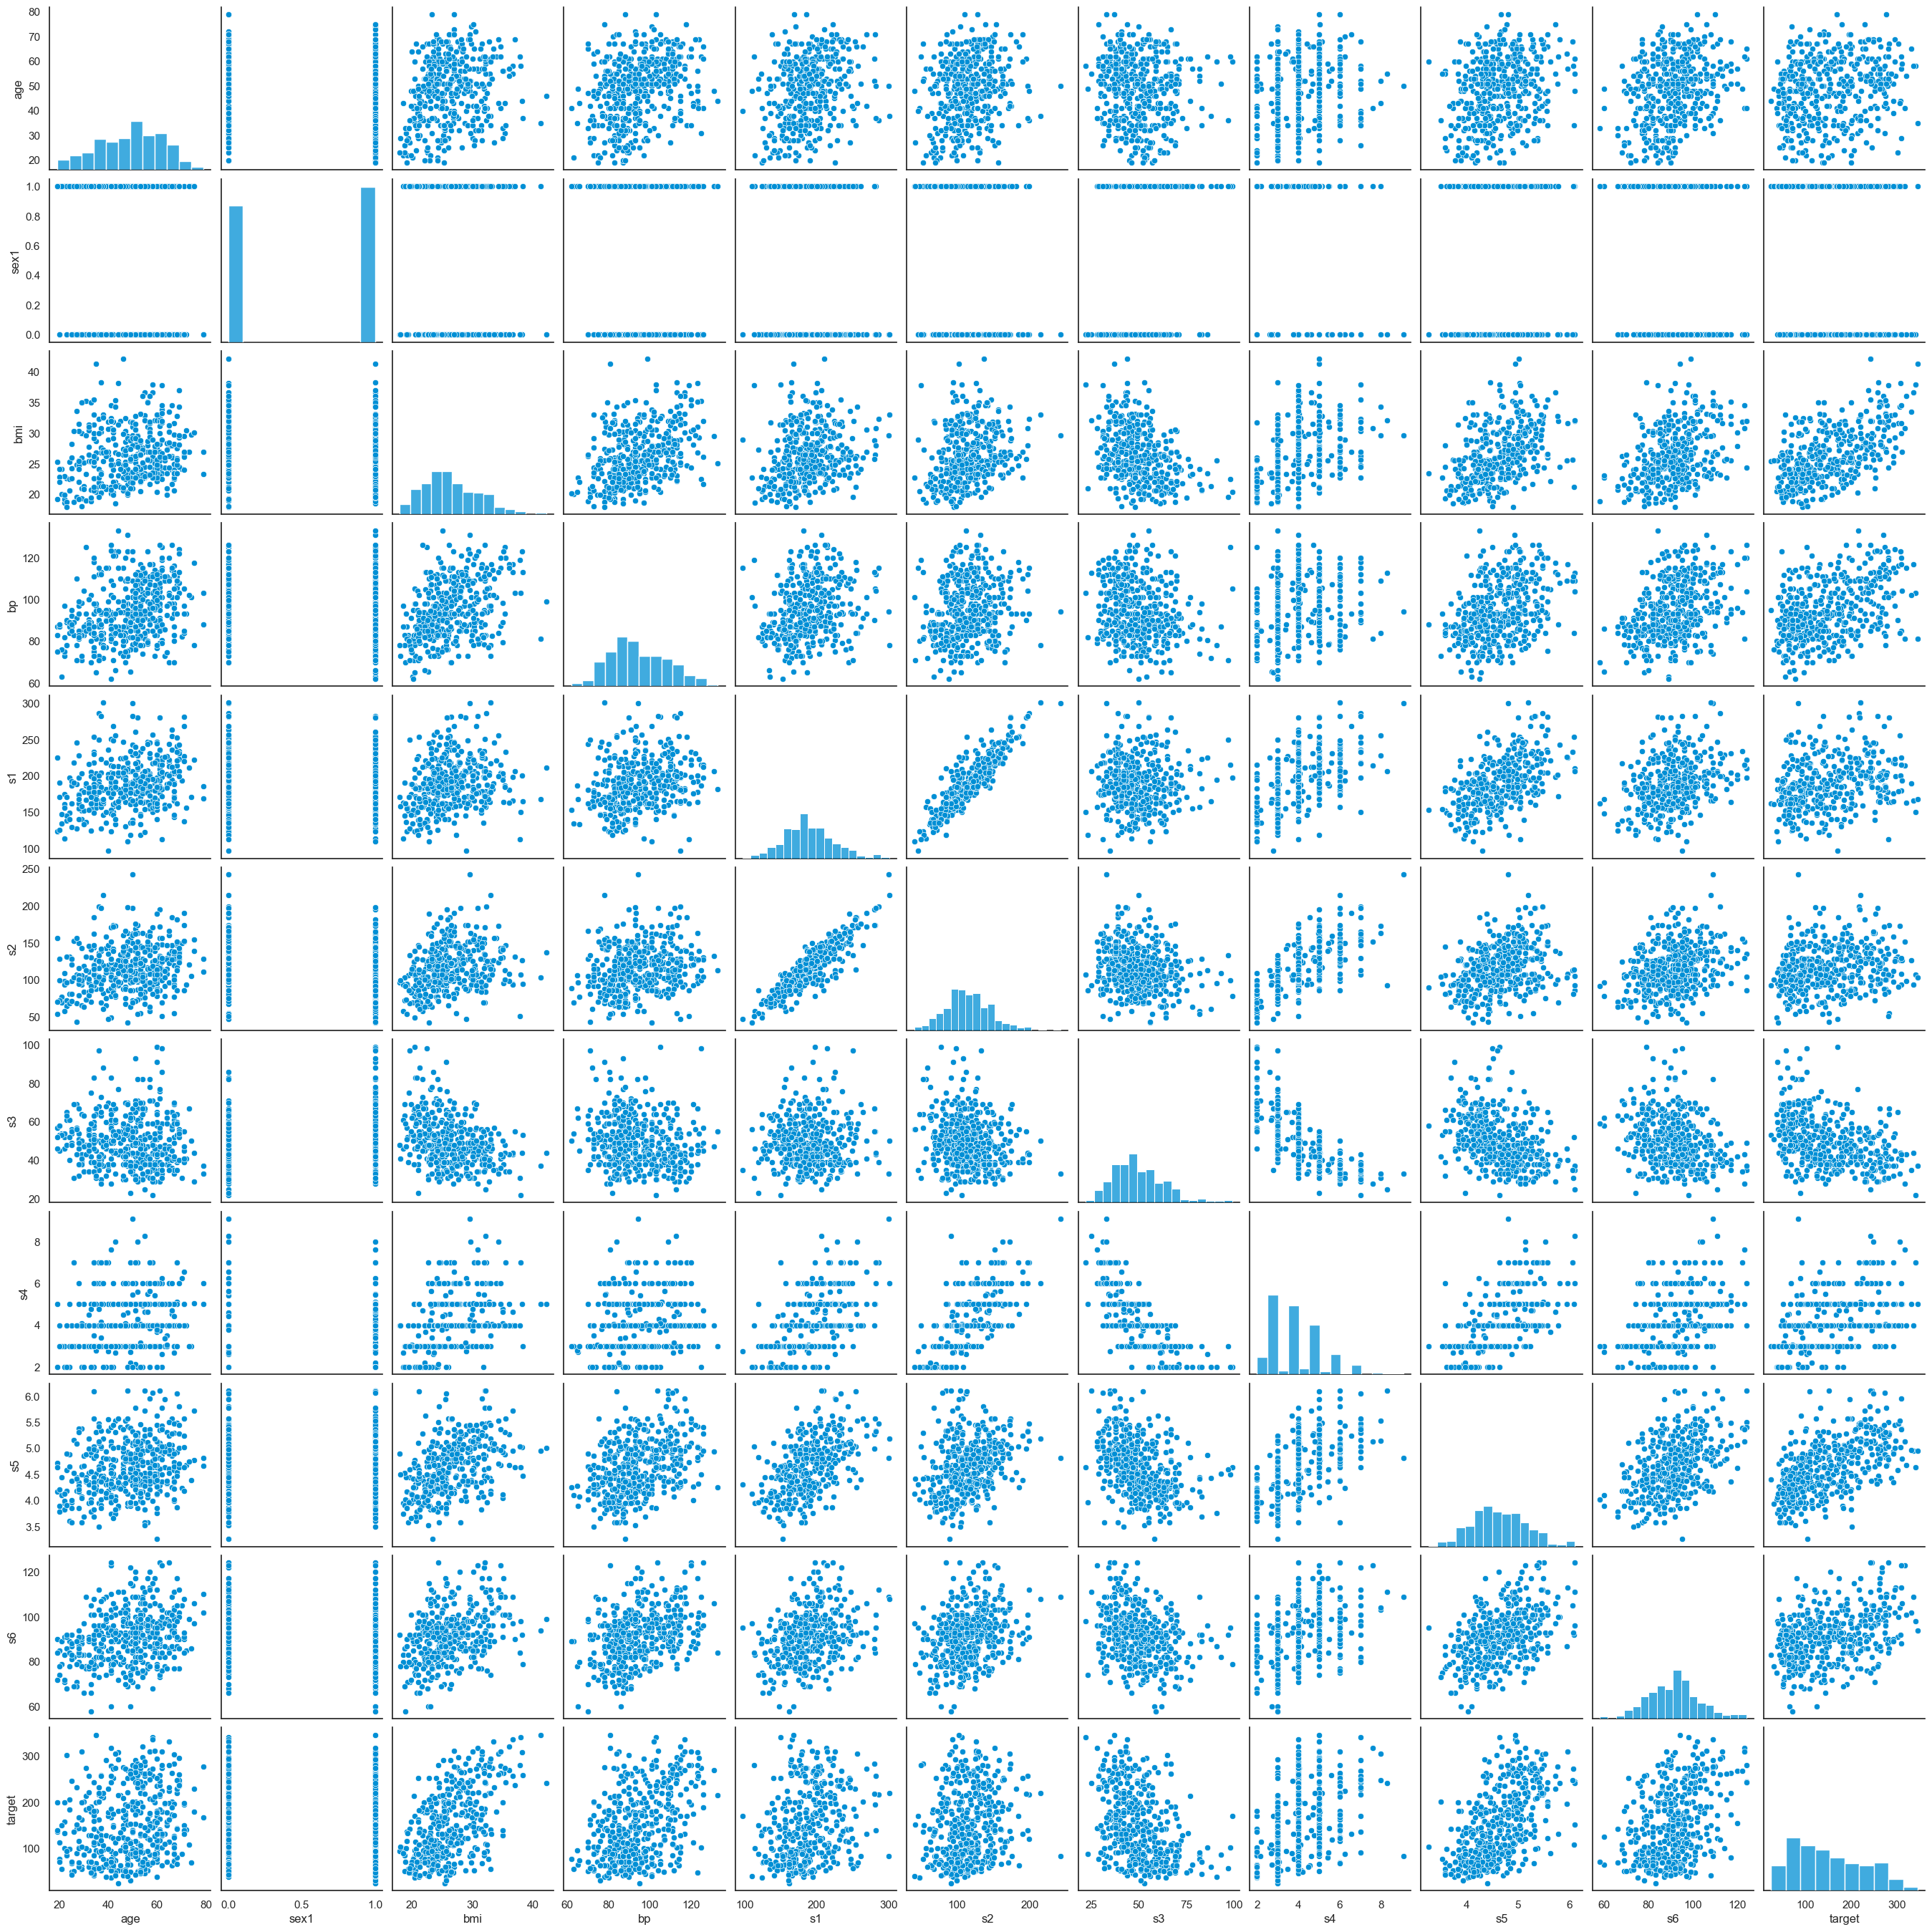

In [26]:
# This code may take a minute or two to finish running
sns.pairplot(diabetes)
plt.show()

DataFrame Head:


age  sex1   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0   0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0   1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0   0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0

DataFrame Tail:


age  sex1   bmi     bp     s1     s2    s3    s4      s5    s6  target
439  60.0   0.0  24.9  99.67  162.0  106.6  43.0  3.77  4.1271  95.0   132.0
440  36.0   1.0  30.0  95.00  201.0  125.2  42.0  4.79  5.1299  85.0   220.0
441  36.0   1.0  19.6  71.00  250.0  133.2  97.0  3.00  4.5951  92.0    57.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



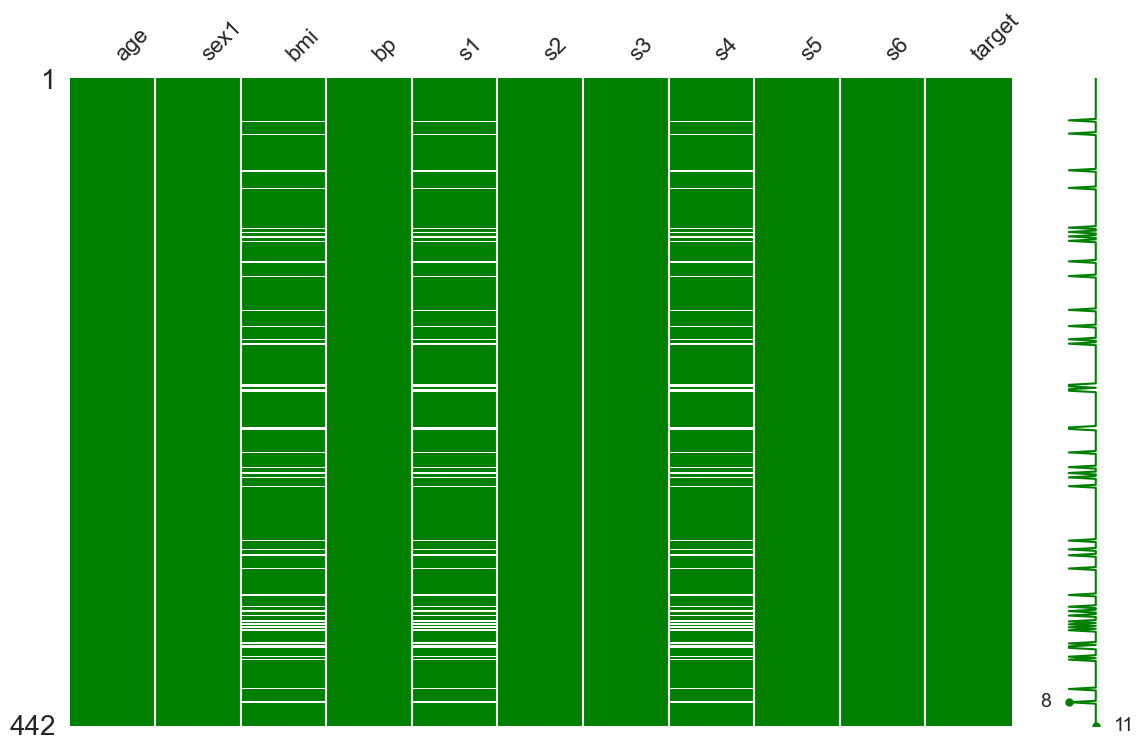

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(442, 11)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex1    442 non-null    float64
 2   bmi     398 non-null    float64
 3   bp      442 non-null    float64
 4   s1      398 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      398 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



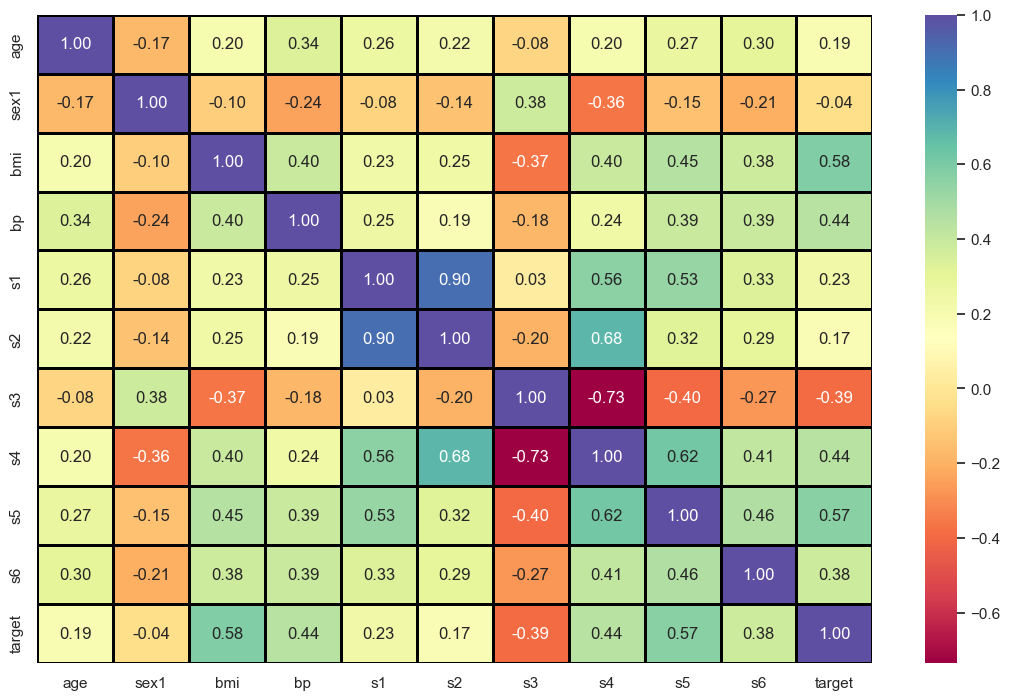

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



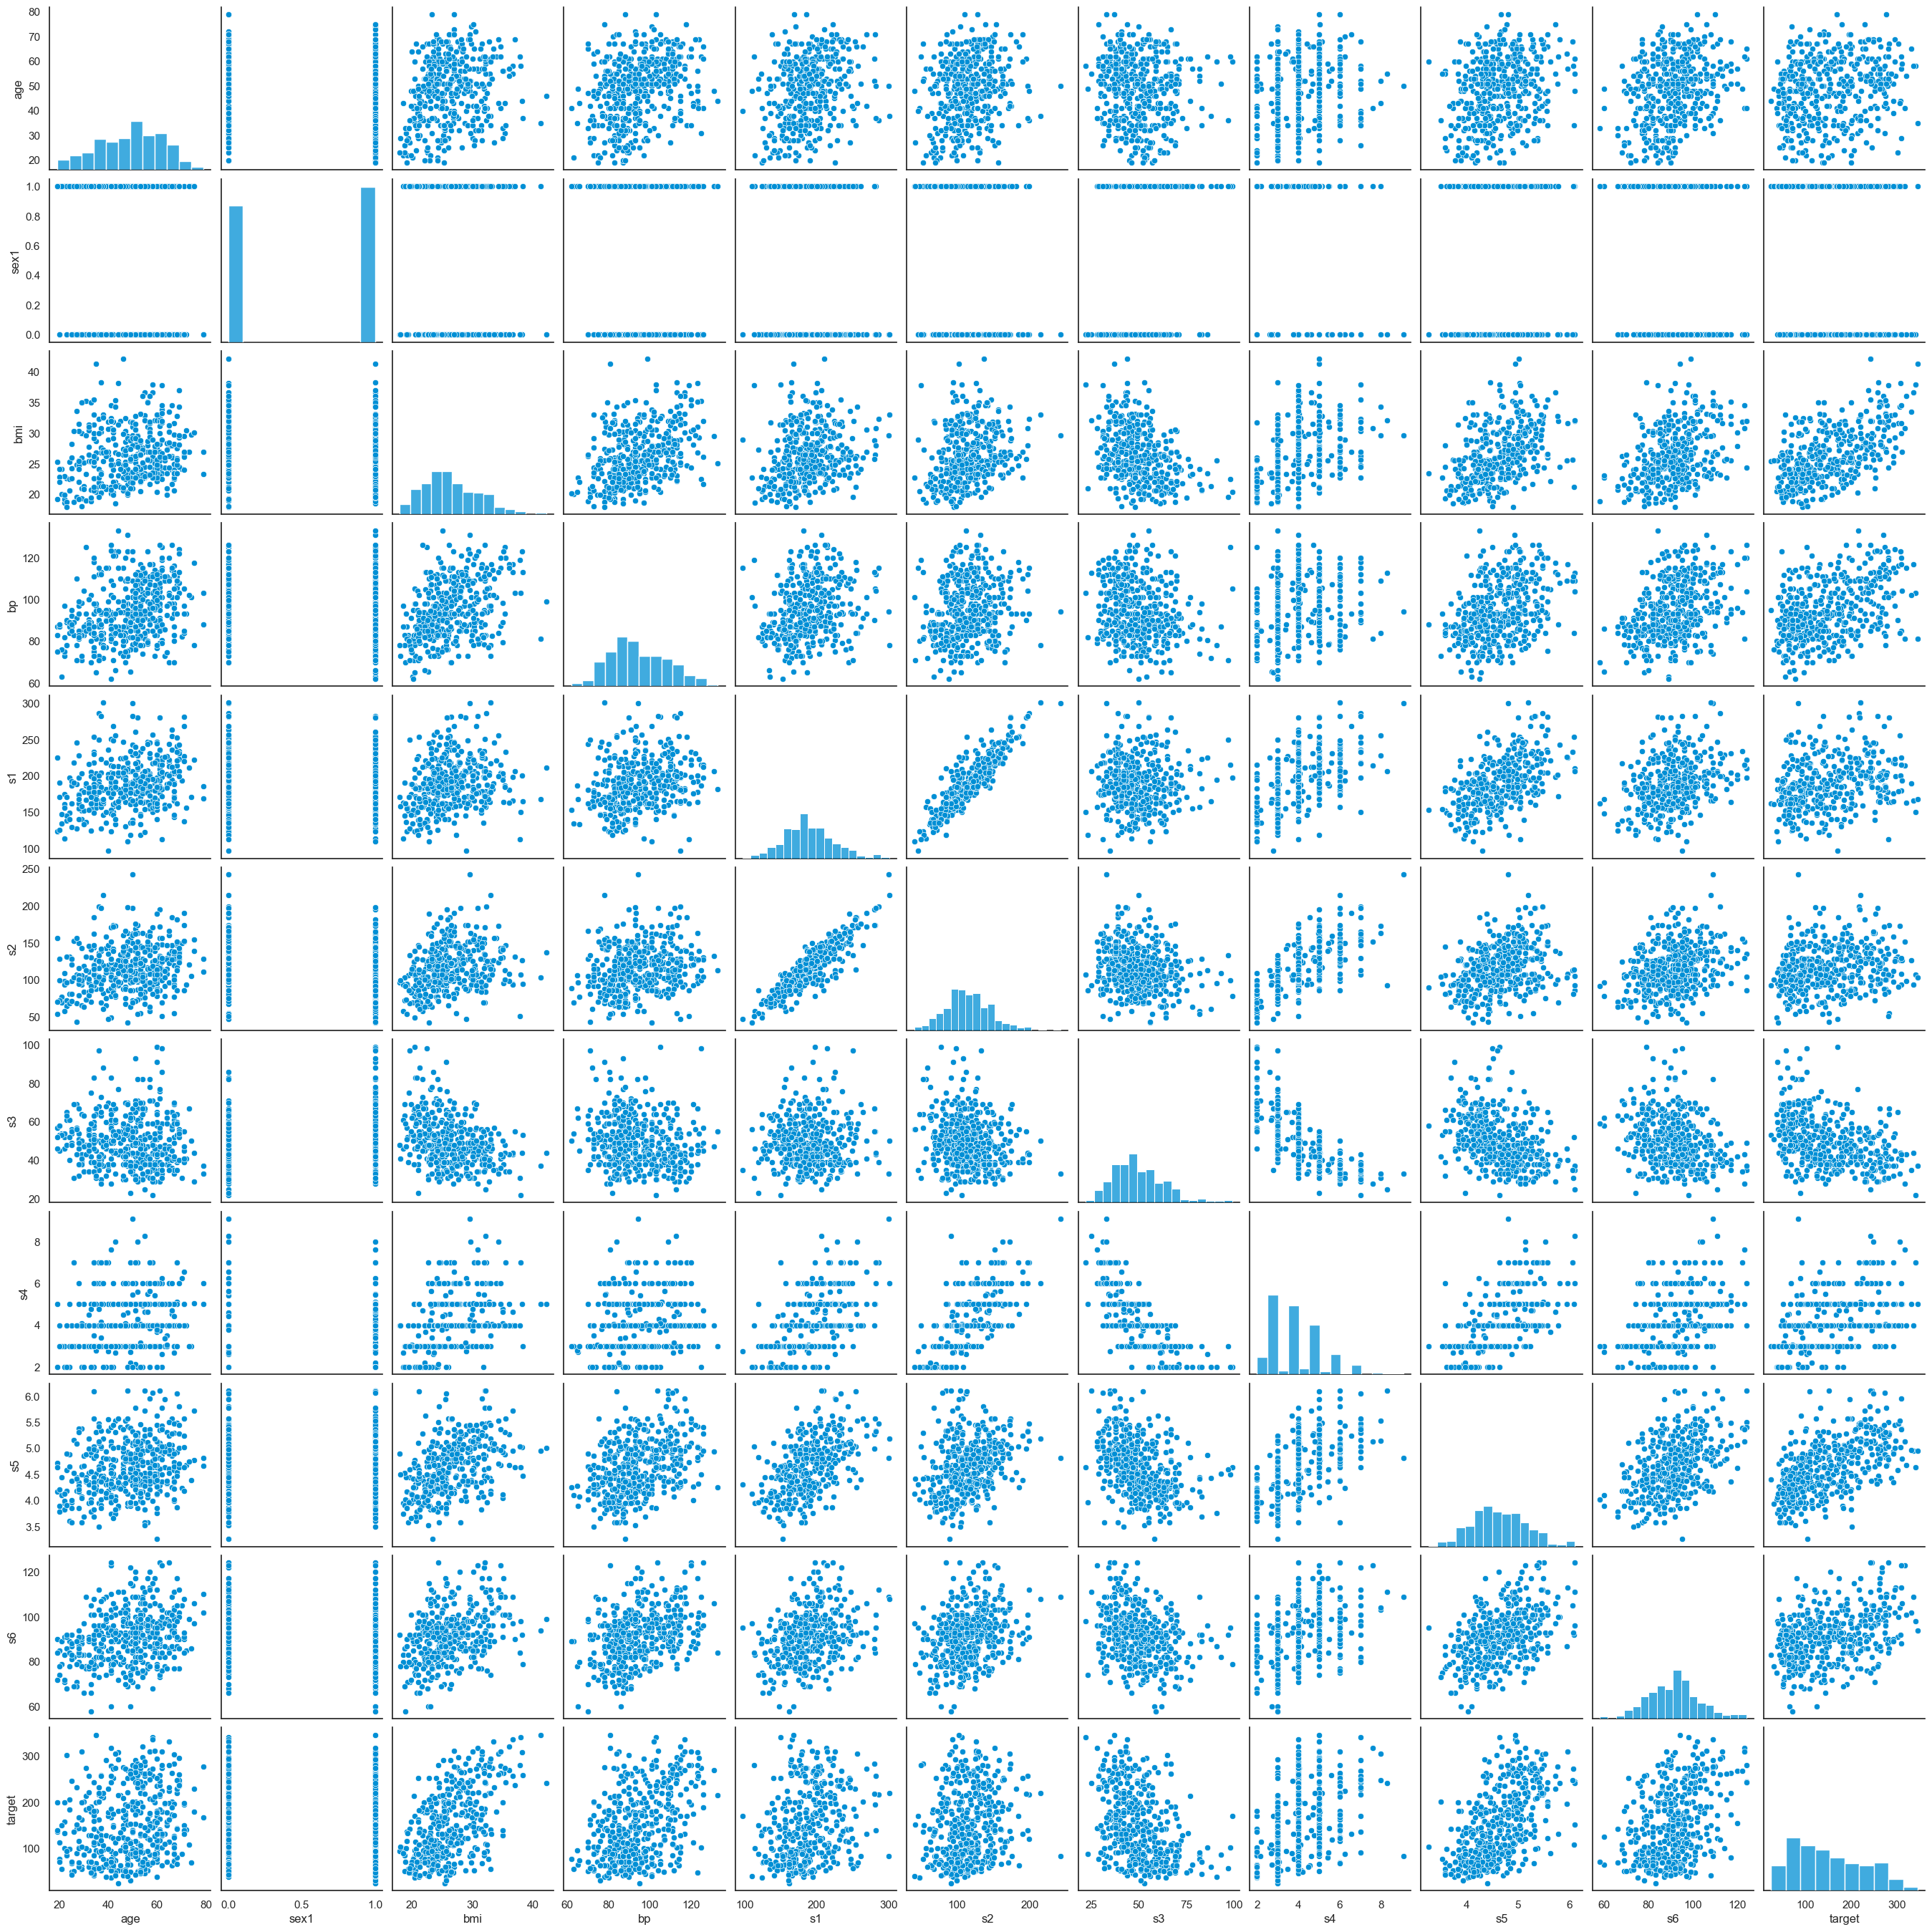

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



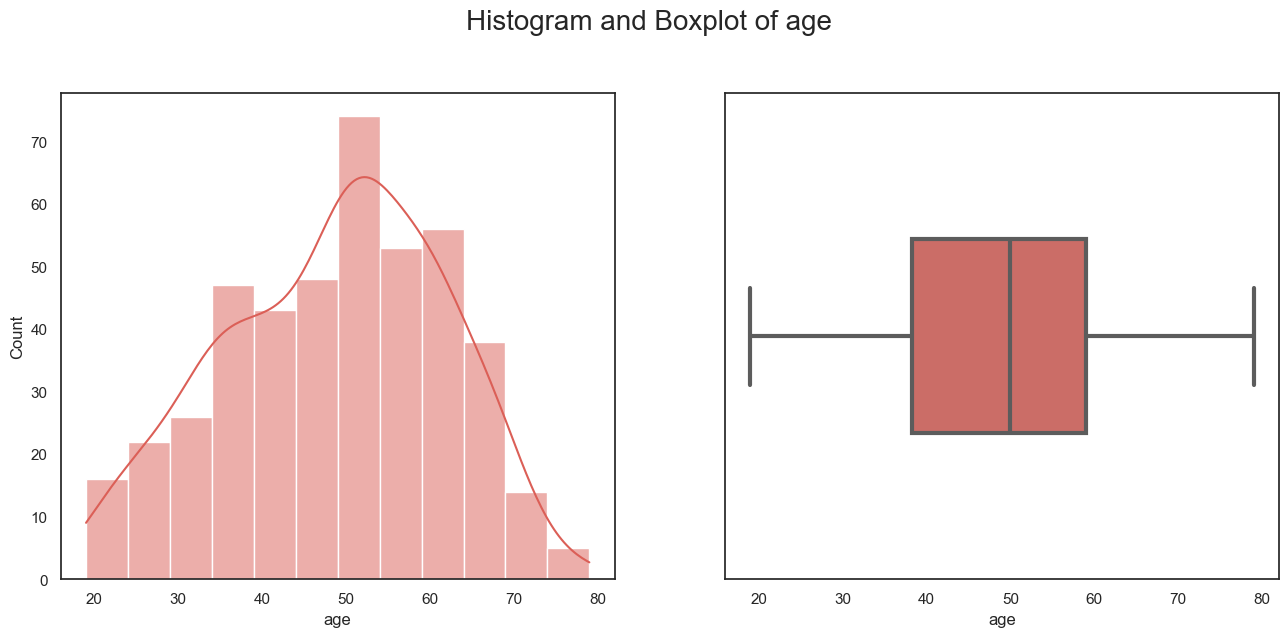

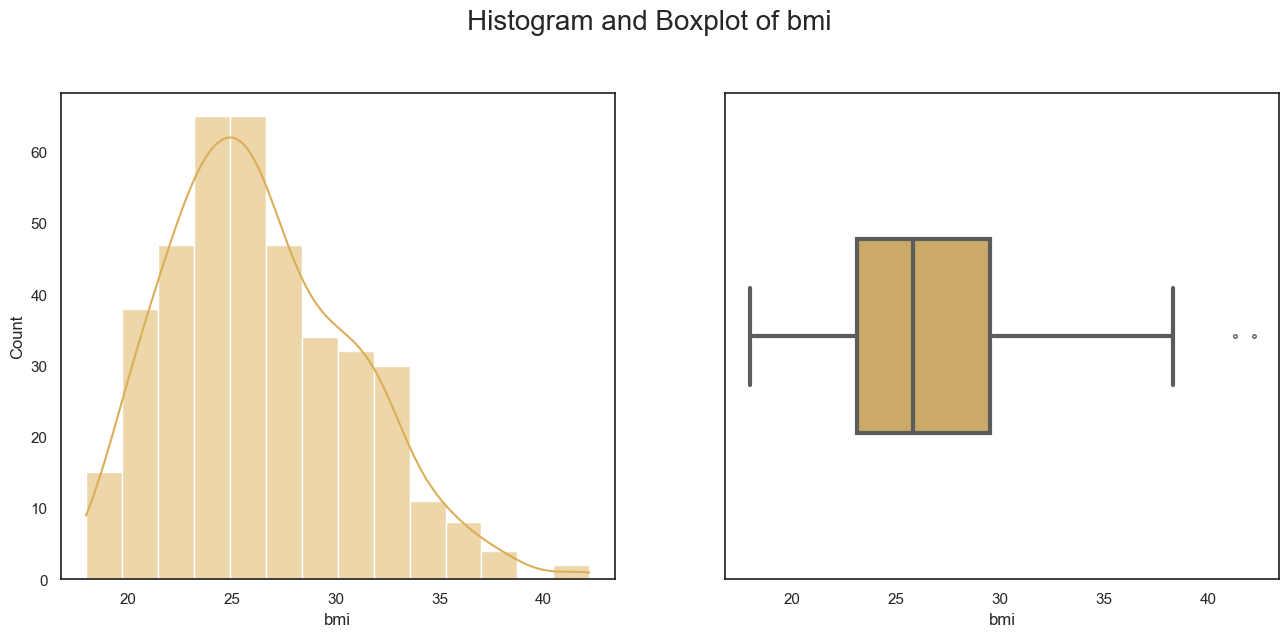

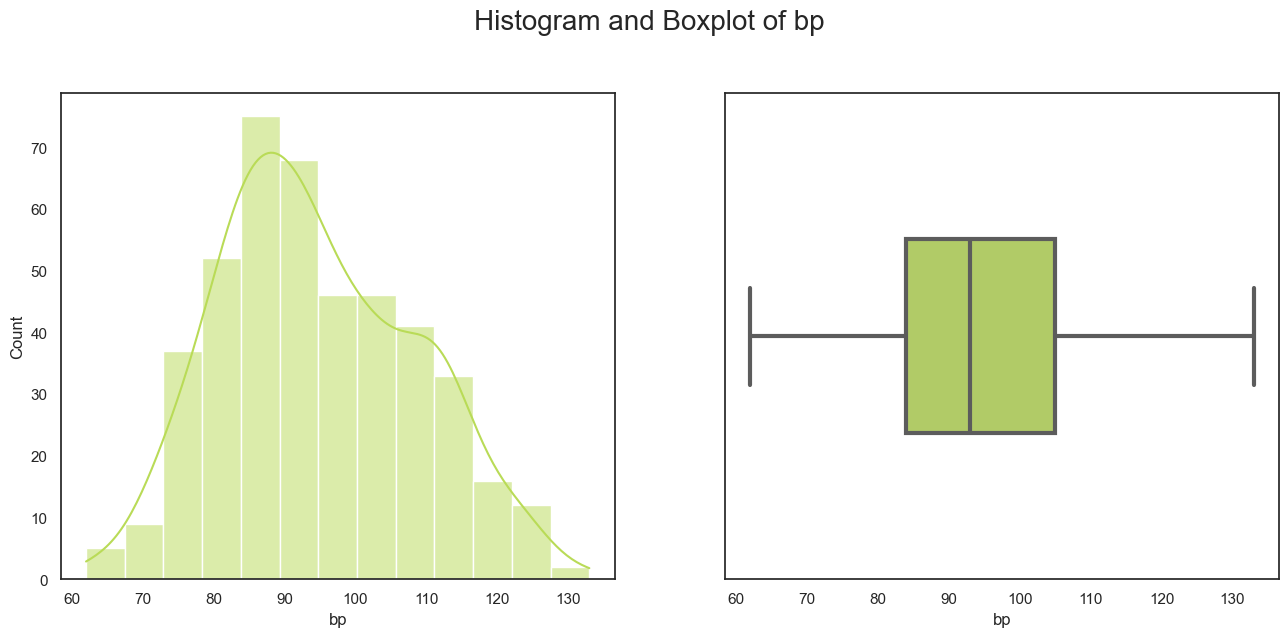

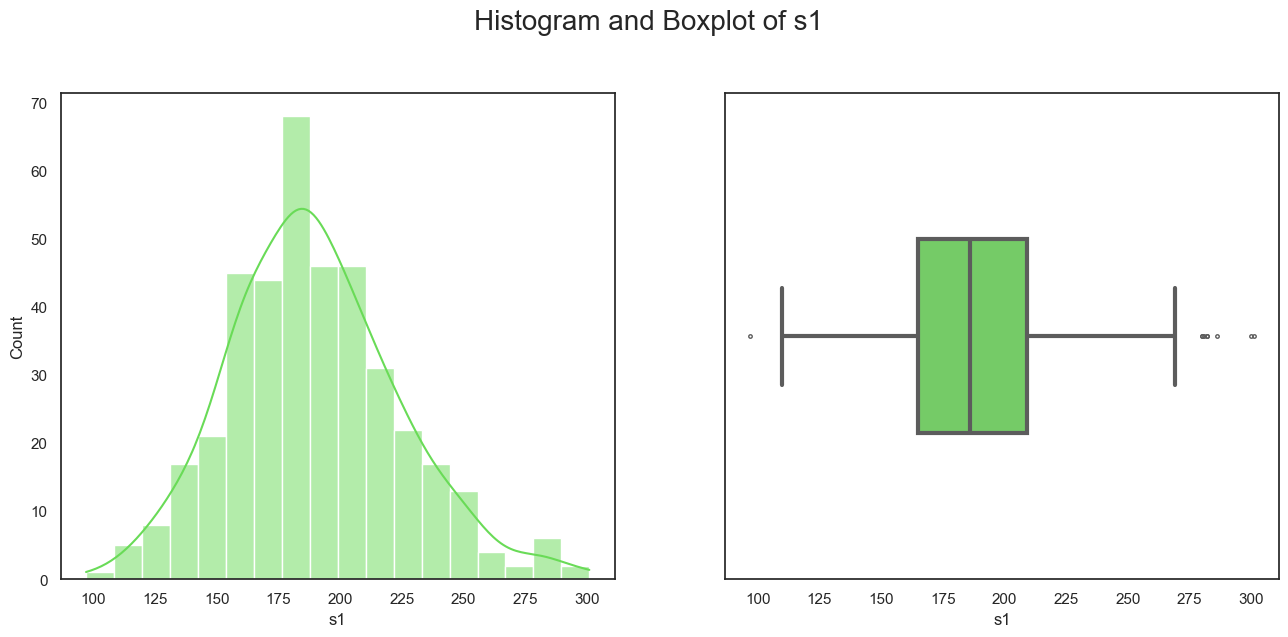

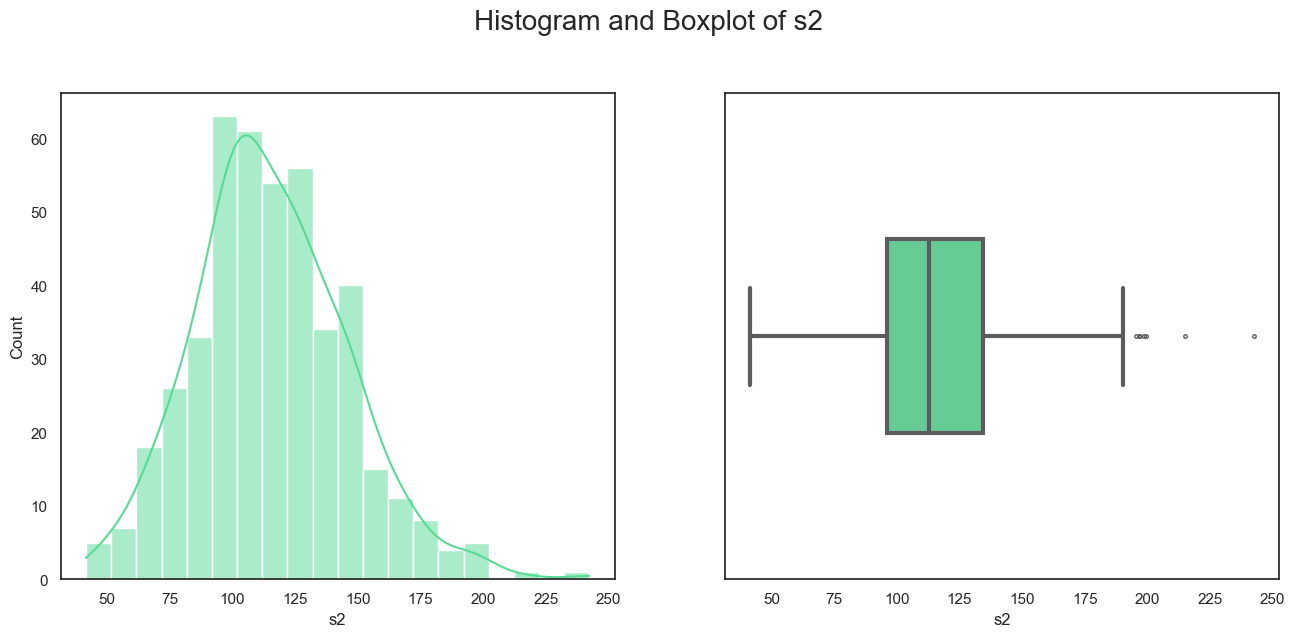

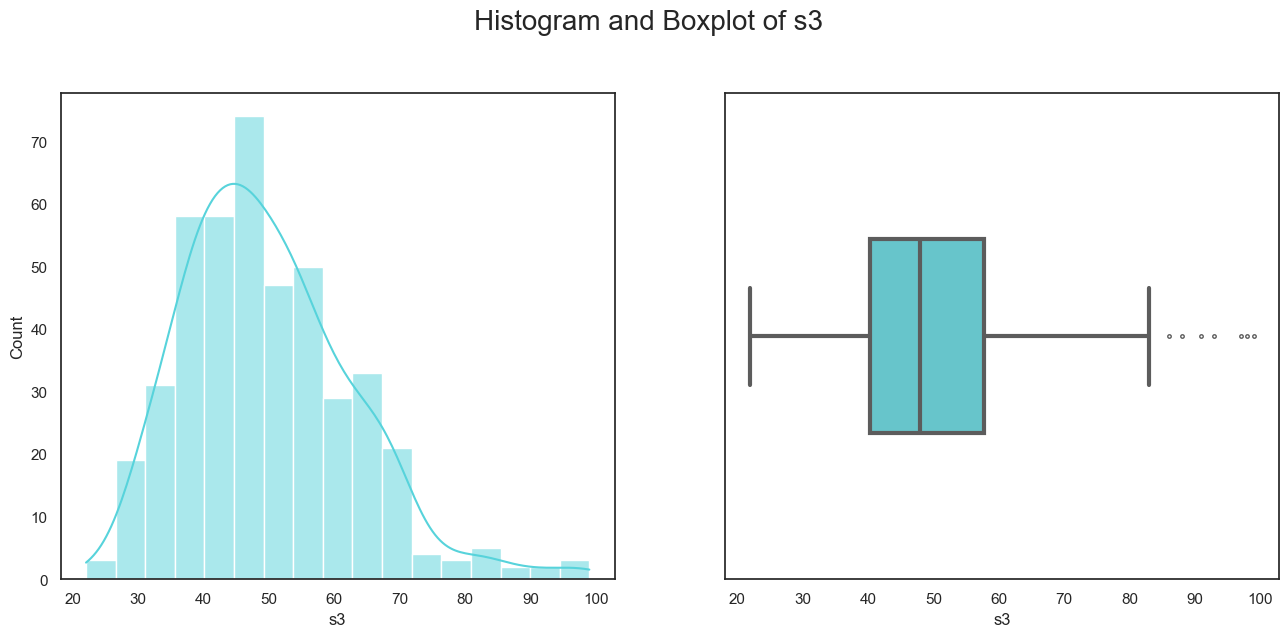

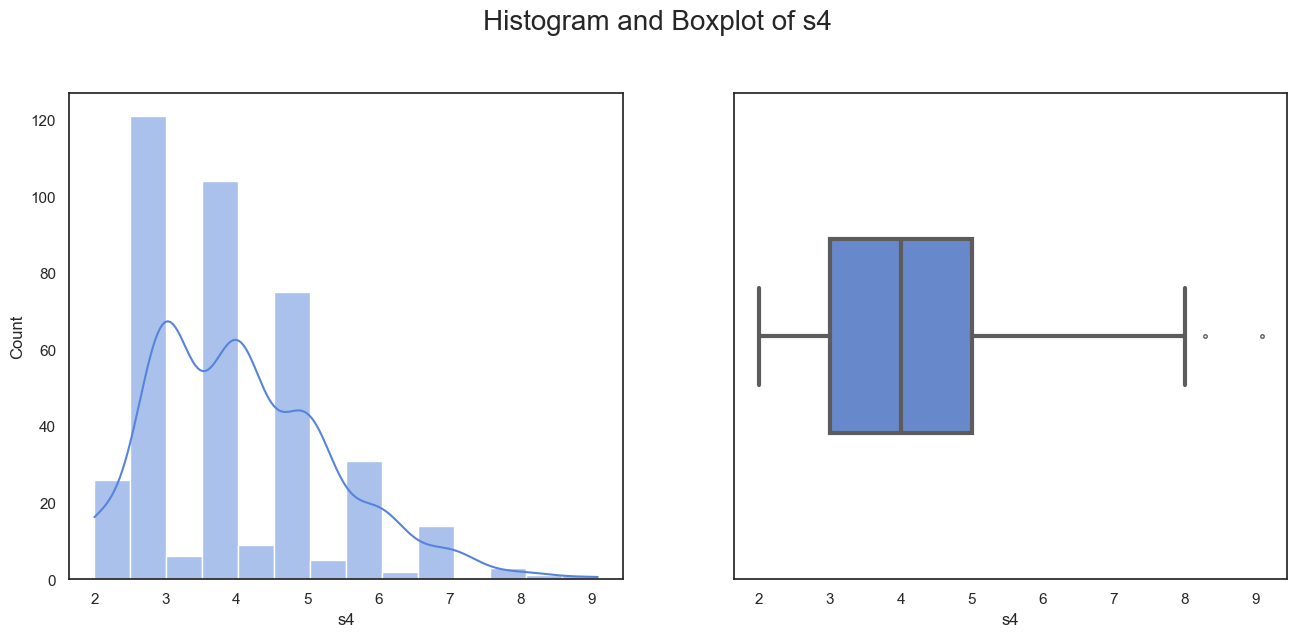

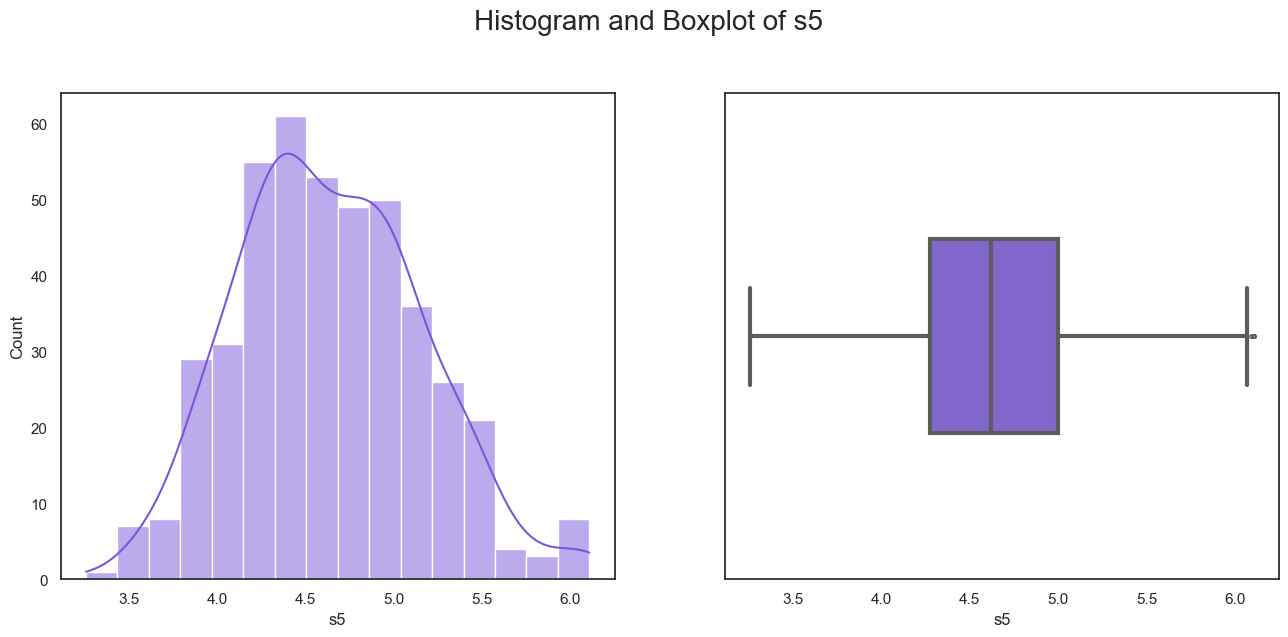

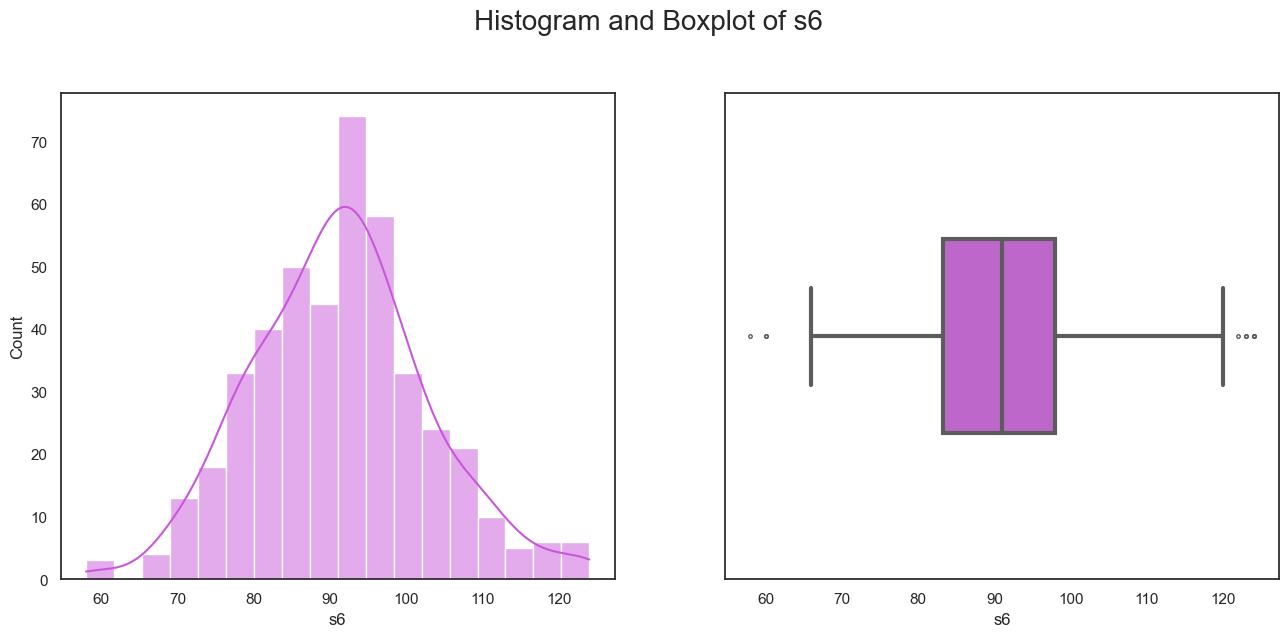

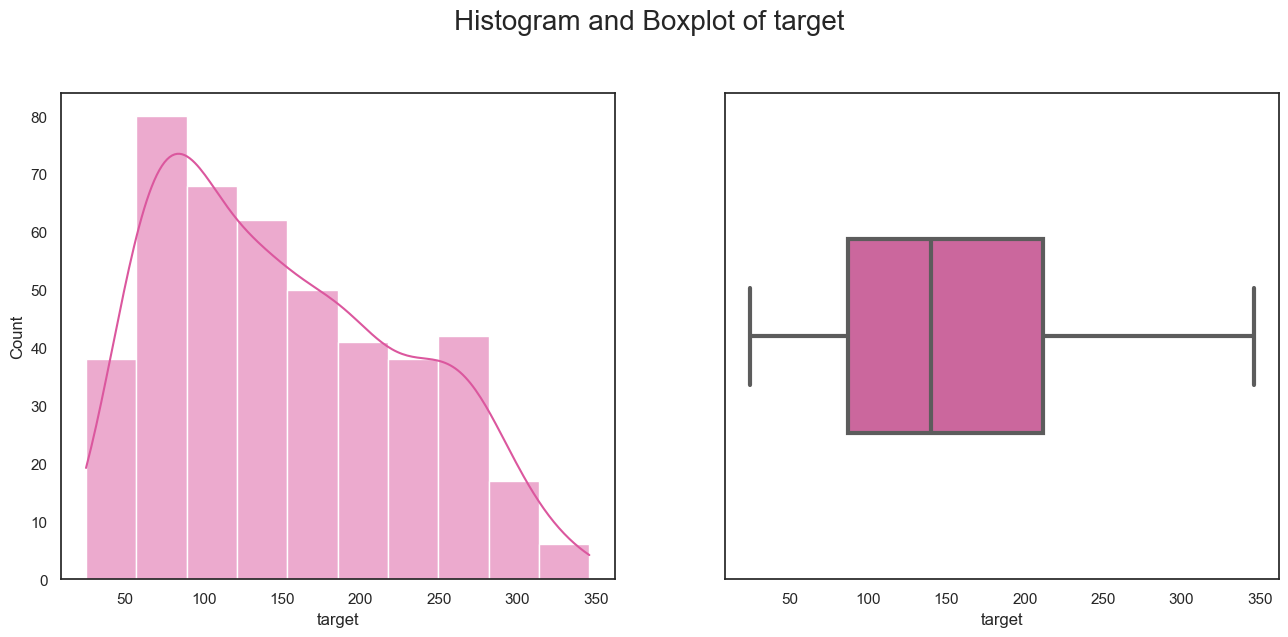

----------------------------------------------------------------------------------------------------
Countplot(s):



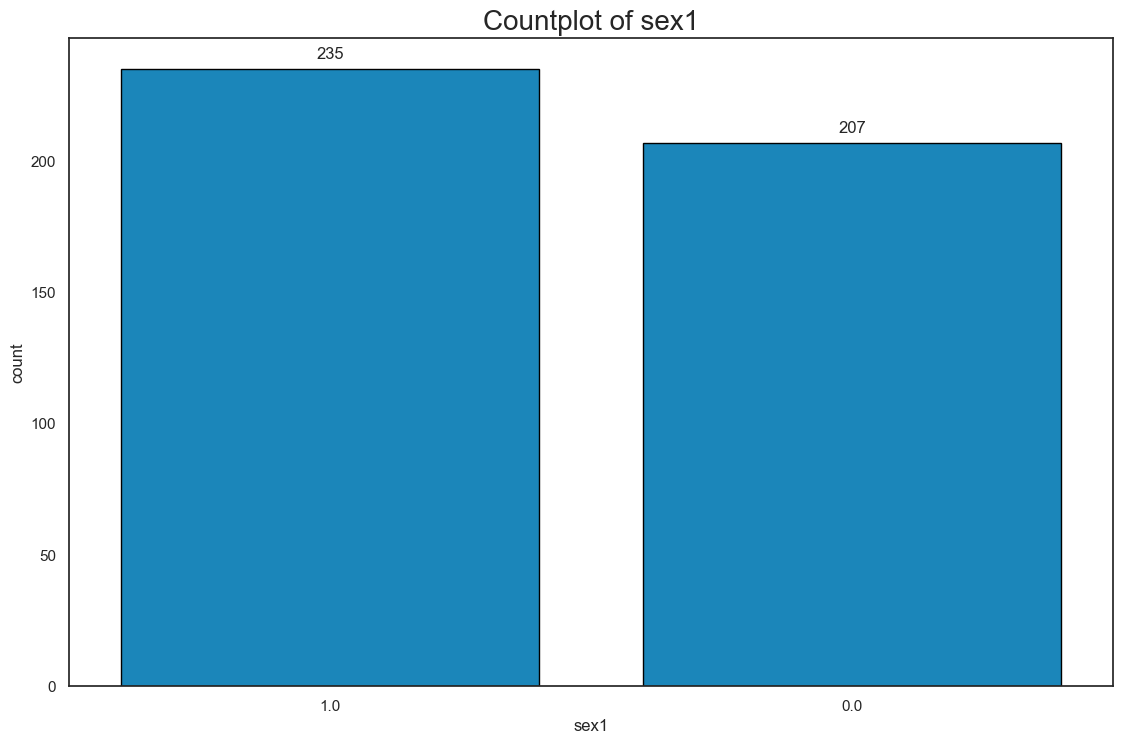

In [27]:
# This code may take a minute or two to finish running
fast_eda(diabetes)

In [28]:
# Load the data set from sklearn
iris_sklearn = load_iris()

# Extract the data and target labels as a numpy array
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis=1)

# Define column names
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Convert the numpy array to a pandas dataframe with column names
iris = pd.DataFrame(iris_npy, columns=col_names)

# Print a description of the dataset
print(iris_sklearn['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [29]:

iris['target'].sample(5)

33     0.0
65     1.0
22     0.0
93     1.0
117    2.0
Name: target, dtype: float64

In [30]:
class_names = dict(zip(list(map(float, range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))
print(class_names)

{0.0: np.str_('setosa'), 1.0: np.str_('versicolor'), 2.0: np.str_('virginica')}


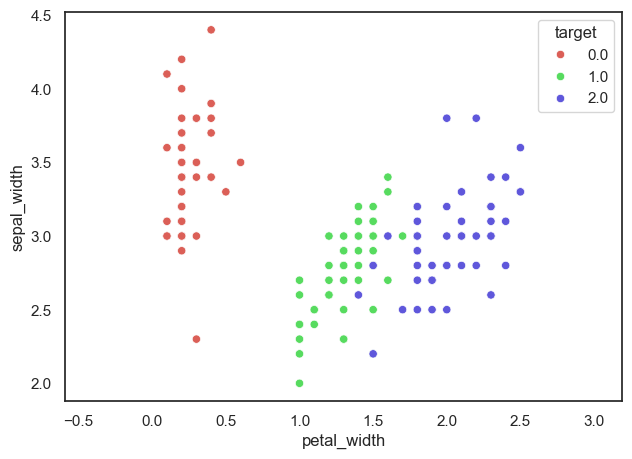

In [31]:
plt.axis('equal')
sns.scatterplot(iris, x='petal_width', y='sepal_width', hue='target', palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

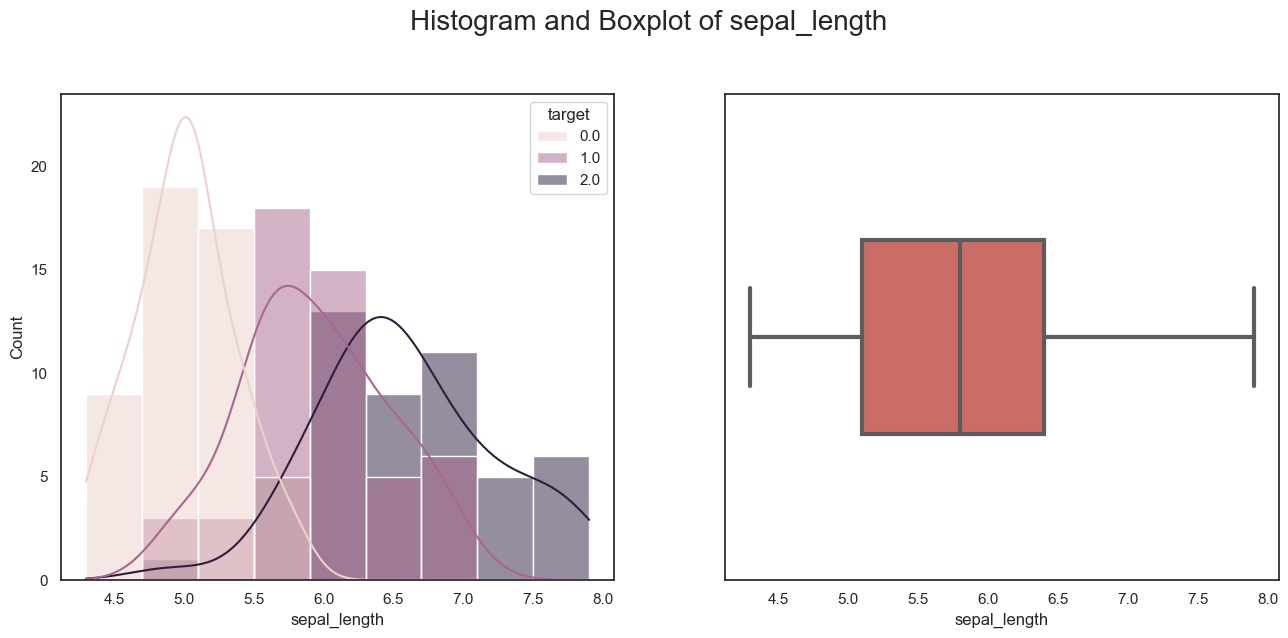

In [32]:
for idx, col in enumerate(['sepal_length']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
    sns.histplot(iris, x = iris[col], kde = True,
                 color = sns.color_palette("hls", iris['target'].nunique()), ax = ax1, hue = 'target')
    sns.boxplot(x = iris[col], width = 0.4, linewidth = 3, fliersize = 2.5,
                color = sns.color_palette("hls", iris['target'].nunique())[idx], ax = ax2)
    fig.suptitle(f"Histogram and Boxplot of {col}", size = 20, y = 1.02)
    plt.show()

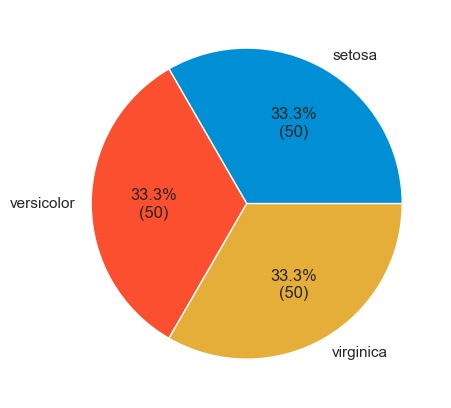

In [33]:
# Inspired by:
#https://stackoverflow.com/questions/73616867/pie-chart-from-count-of-values-showing-the-percentage/73617021#73617021

# Define a function to format value counts into percentages
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc, labels = vc.rename(class_names).index, autopct=autopct_format(vc))